In [1]:
#Solo correr en Deepnote
import os
path = r'/work/online_retail_analysis'
os.chdir(path)
!pip install --editable .
!pip install pyprojroot
# !pip install openpyxl

'/work/online_retail_analysis/notebooks'

In [16]:
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### import library

In [17]:
import online_retail_analysis.utils.paths as path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer ,StandardScaler
from sklearn.cluster import MiniBatchKMeans as KMeans

# sns.set_style("whitegrid")
%matplotlib inline
pd.options.display.float_format = '{:,.3f}'.format

### import data

In [18]:
df_proces = pd.read_csv(path.data_processed_dir('data_clean.csv'))
df_proces['InvoiceDate']= pd.to_datetime(df_proces['InvoiceDate'])

In [19]:
df_proces.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
date           0
month          0
days           0
cost           0
dtype: int64

### RFM Segmetation

In [24]:
from online_retail_analysis.features.build_features import Calculate_RFMV , score_rfmv , check_skew

df_rfm = Calculate_RFMV(df_proces, 'CustomerID')#CustomerID - StockCode
df_rfm_score = score_rfmv(df_rfm)
df_rfm_score

,Recency,MonetaryValue,Frequency,Variety,Total_Score
CustomerID,,,,,
"12,346.000",326,37.440,1,1,4
"12,347.000",2,"4,015.210",182,103,16
"12,348.000",75,732.620,31,22,9
"12,349.000",19,"1,389.150",73,73,12
"12,350.000",310,302.900,17,17,6
...,...,...,...,...,...
"18,280.000",278,177.700,10,10,4
"18,281.000",181,63.920,7,7,4
"18,282.000",8,162.250,12,12,7


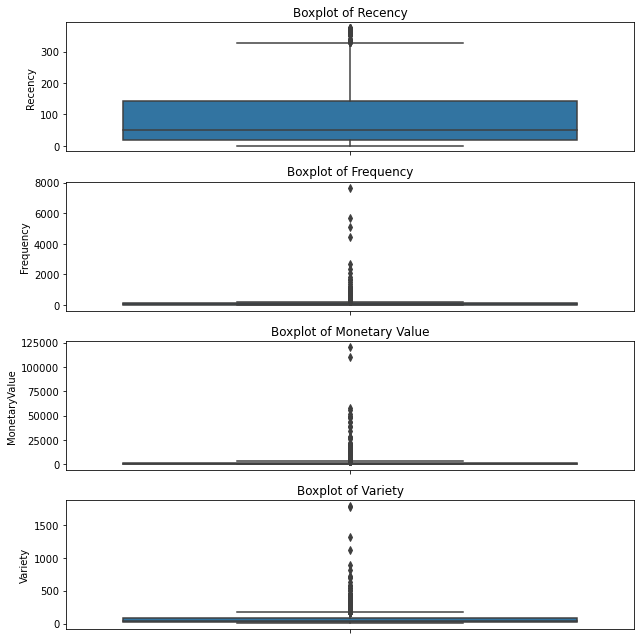

In [25]:
from online_retail_analysis.visualization.visualize import boxplot_vis , plot_distribution_and_skew_test
boxplot_vis(df_rfm_score)


In [26]:
def rm_outliers(df, col):
    p_05 = df[col].quantile(0.05) # 5th quantile
    p_95 = df[col].quantile(0.95) # 95th quantile
    df[col].clip(p_05, p_95, inplace=True)
    return df

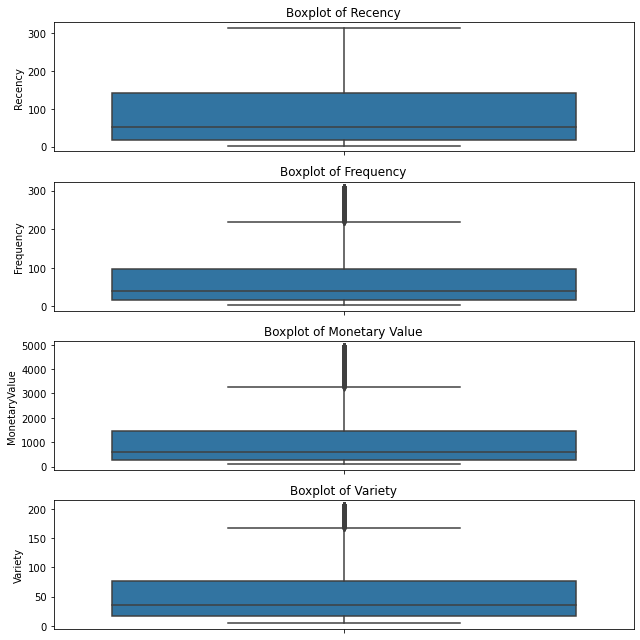

In [27]:
rfm_copy = df_rfm_score.copy()
rm_outliers(rfm_copy , 'Recency')
rm_outliers(rfm_copy , 'Frequency')
rm_outliers(rfm_copy , 'MonetaryValue')
rm_outliers(rfm_copy , 'Variety')

boxplot_vis(rfm_copy)

Recency's: Skew: 1.1216760670663248, : SkewtestResult(statistic=24.707286046845308, pvalue=8.930520132664315e-135)
Frequency's: Skew: 1.621498296379552, : SkewtestResult(statistic=31.64097348083877, pvalue=1.0093366446246754e-219)
MonetaryValue's: Skew: 1.708583662438927, : SkewtestResult(statistic=32.676020766861264, pvalue=3.422522802008332e-234)
Variety's: Skew: 1.397370876105671, : SkewtestResult(statistic=28.760299534832466, pvalue=6.733396027580096e-182)


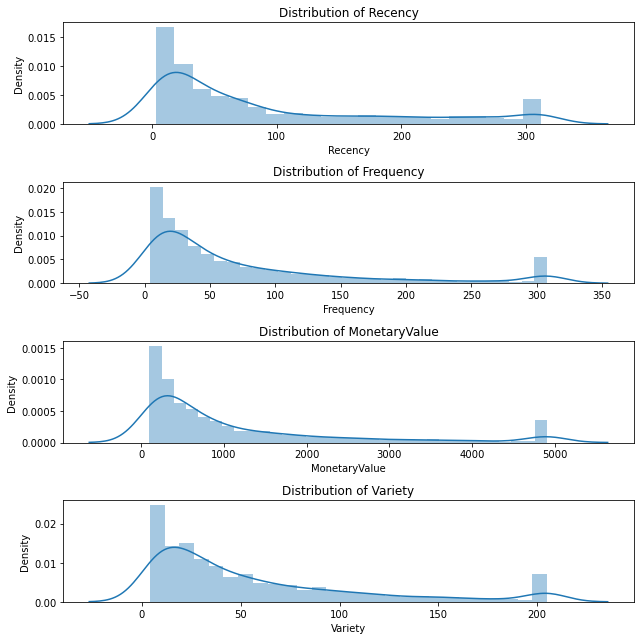

In [28]:
plot_distribution_and_skew_test(rfm_copy)
# plt.savefig(path.reports_figures_dir('before_transform.png'), format='png', dpi=1000)

Recency's: Skew: -0.36373885171536413, : SkewtestResult(statistic=-9.500574744218628, pvalue=2.087350114028487e-21)
Frequency's: Skew: -0.12635014469905967, : SkewtestResult(statistic=-3.3898658323962985, pvalue=0.0006992683804833991)
MonetaryValue's: Skew: 0.13548688066607784, : SkewtestResult(statistic=3.632874194610304, pvalue=0.0002802816903238514)
Variety's: Skew: -0.23201924904150203, : SkewtestResult(statistic=-6.168643641044673, pvalue=6.887826249280373e-10)


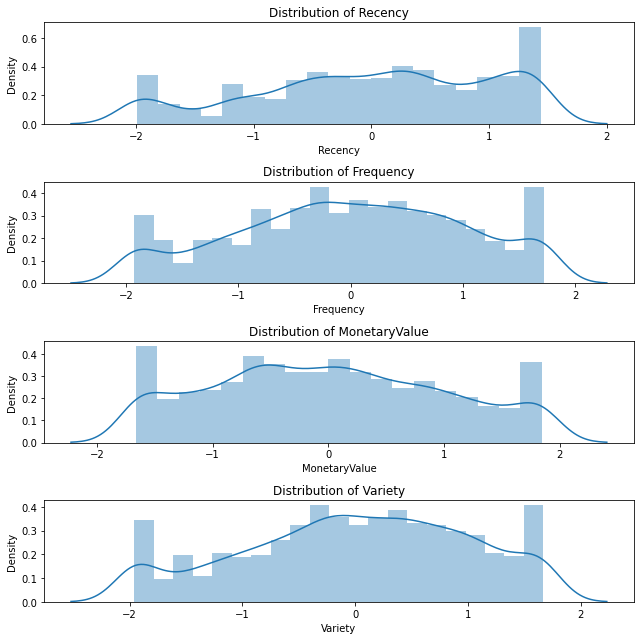

In [29]:

transformer = FunctionTransformer(np.log)
new_rfm_trans_log = transformer.fit_transform(rfm_copy)
scaler = StandardScaler()
new_rfm_trans_log_sc = scaler.fit_transform(new_rfm_trans_log)
new_rfm_trans_log_sc = pd.DataFrame(new_rfm_trans_log_sc, columns=new_rfm_trans_log.columns)

plot_distribution_and_skew_test(new_rfm_trans_log_sc)
# plt.savefig(path.reports_figures_dir('after_transform_Scaler.png'), format='png', dpi=1000)

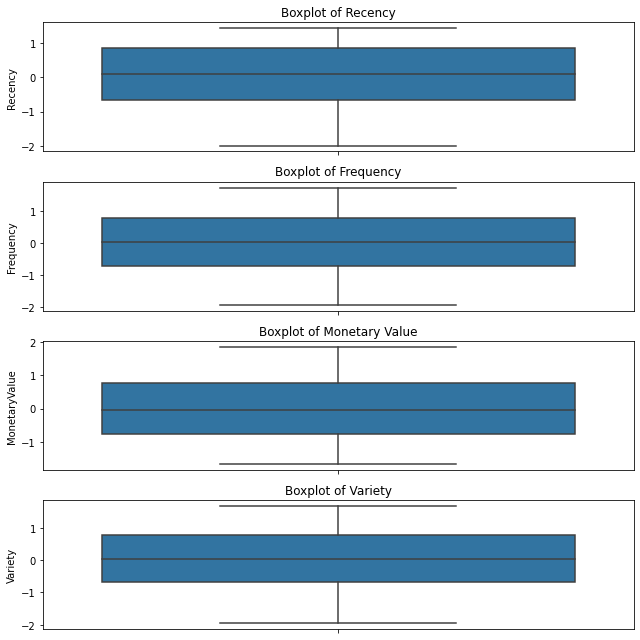

In [30]:
boxplot_vis(new_rfm_trans_log_sc)

Variety's: Skew: -0.23201924904150203, : SkewtestResult(statistic=-6.168643641044673, pvalue=6.887826249280373e-10)


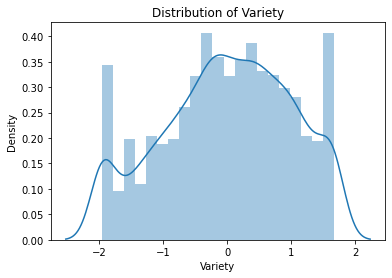

In [31]:
check_skew(new_rfm_trans_log_sc,'Variety')

### K-Means cluster

In [32]:
from online_retail_analysis.models.train_model import train_elbow_cluster

# def train_elbow_cluster(train,start=1,finish=10,each=1):
#     wcss = {} #dicionario vacio para guardar los errores
#     for i in range(start,finish,each):
#         kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
#         kmeans.fit(train)
#         wcss[i] = kmeans.inertia_ #suma de distancias cuadradas a los centros del grupos más cercanos
#     plt.title('Metodo de Elbow ')
#     plt.xlabel('k= n grupos')
#     plt.ylabel('WCSS')
#     sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
#     plt.show()
#    return wcss 

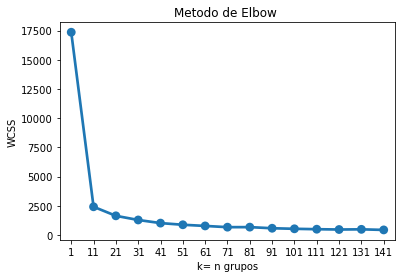

In [33]:
X = np.asarray(new_rfm_trans_log_sc.drop('Total_Score', 1))
train_elbow_cluster(X,finish=150,each=10)

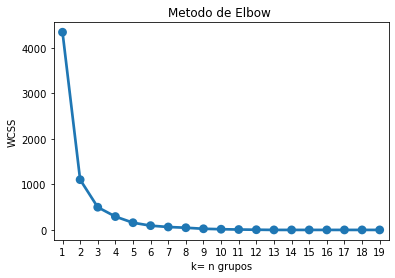

In [34]:
new_rfm_trans_log_sc[['Total_Score']]
X = np.asarray(new_rfm_trans_log_sc[['Total_Score']])
X
train_elbow_cluster(X,finish=20,each=1)


In [35]:
def Kmeans(train, clusters_number, original_df_rfm):
    kmeans = KMeans(n_clusters = clusters_number, random_state = 42)
    # Predict the cluster
    y_kmeans = kmeans.fit_predict(train)
    # Create a cluster label column in original dataset
    df_cluster = original_df_rfm.assign(Cluster = y_kmeans)
    return df_cluster

In [36]:
X.shape

(4338, 1)

In [37]:
rfm_k4 = Kmeans(X, 4, df_rfm.drop('CustomerID',1))

rfm_k5 = Kmeans(X, 5, df_rfm.drop('CustomerID',1))

rfm_k6 = Kmeans(X, 6, df_rfm.drop('CustomerID',1))
rfm_k4

,Recency,MonetaryValue,Frequency,Variety,Total_Score,Cluster
CustomerID,,,,,,
"12,346.000",326,37.440,1,1,4,2
"12,347.000",2,"4,015.210",182,103,16,1
"12,348.000",75,732.620,31,22,9,0
"12,349.000",19,"1,389.150",73,73,12,3
"12,350.000",310,302.900,17,17,6,2
...,...,...,...,...,...,...
"18,280.000",278,177.700,10,10,4,2
"18,281.000",181,63.920,7,7,4,2
"18,282.000",8,162.250,12,12,7,0


In [38]:
def snake_plot(normalised_df_rfm):
    normalised_df_rfm = normalised_df_rfm.reset_index()
    normalised_df_rfm = normalised_df_rfm[['CustomerID', 'Cluster','Recency', 'Frequency', 'MonetaryValue', 'Variety']]
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue', 'Variety'], 
                    var_name='Metric', 
                    value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    return

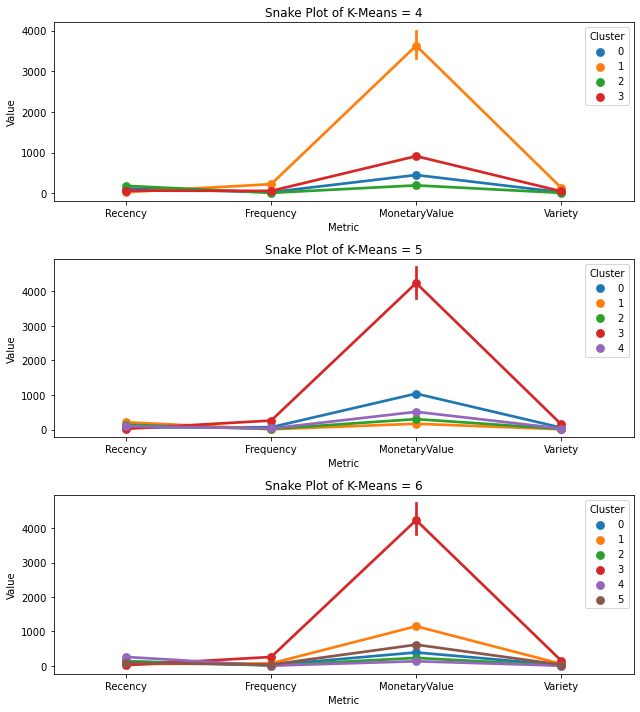

In [39]:
plt.figure(figsize=(9, 10))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 4')
snake_plot(rfm_k4)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 5')
snake_plot(rfm_k5)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 6')
snake_plot(rfm_k6)

plt.tight_layout()

## Evaluation model
### Davies bouldin Score: The smaller Davies Bouldin Score is The more optimal the cluster.

In [40]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
print('davies score to k=4: {}'.format(davies_bouldin_score(X, rfm_k4.Cluster)))
print('davies score to k=5: {}'.format(davies_bouldin_score(X, rfm_k5.Cluster)))
print('davies score to k=6: {}'.format(davies_bouldin_score(X, rfm_k6.Cluster)))

davies score to k=4: 0.4783924908107352
davies score to k=5: 0.488868046965384
davies score to k=6: 0.4546168855683769


K-Means with 6 clusters has lowest davies bouldin score than other cluster. Therefore the optimum cluster is 6.

### Silhouetter Score: The higher Silhouuter Score is the more optimal the cluster.

In [41]:
print('davies score to k=4: {}'.format(silhouette_score(X, rfm_k4.Cluster)))
print('davies score to k=5: {}'.format(silhouette_score(X, rfm_k5.Cluster)))
print('davies score to k=6: {}'.format(silhouette_score(X, rfm_k6.Cluster)))


davies score to k=4: 0.6103948244269265
davies score to k=5: 0.6342318994173525
davies score to k=6: 0.6815162967999854


K-Means with 6 clusters has higher Silhoutter score than other cluster. Therefore the optimum cluster is 6.

In [ ]:
rfm_k6.reset_index().to_csv(path.data_processed_dir('data_clustering.csv'),index=False)

In [ ]:
rfm_k6

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2ad5389b-d0fe-4f26-b030-dadc57d353b7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>